In [ ]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Random Kaczmarz with Time Varying Noise Exploration

To begin our exploration, we create a random matrix $A$ (each entry in the matrix is randomly sampled from a uniform distribution over $[0, 1)$, a random vector $x$, and $b^*$, which is defined with $Ax=b^*$.

In [ ]:
A = np.asmatrix(np.random.rand(2000,100))
x = np.random.rand(A.shape[1],1)
b = A*x

In [ ]:
m = A.shape[0]

$Ax=b^*$ is an overdetermined consistent system with $m=2000$ rows and $n=100$ columns.

For our research we are concerned with overdetermined systems of the form $Ax=b^*$ where $b^*$ has either been affected by sparse corruptions or by some noise. In this case, when we attempt to find the solution for $Ax=b^*$, we are only given $b=b^* + b_c + r$, where $b_c$ is a column vector where most entries are $0$ and the non-zero entries can be arbitrarily large, and where $r$ is a column vector with random entries according to some distribution.

In this notebook we will only be looking at the case in which $b^*$ has been affected by noise. In this case, I am using noise which is randomly sampled according to a gaussian distribution with $0$ as its mean and $0.1$ as the size of its standard deviations.

In [ ]:
noise = np.random.normal(0, 0.1, size=(m,1))

One question that we had was whether or not we could use the fact that we expect the noise to be mean zero to attempt to recover $b^*$ or a value closer to it than just the value of $b$ which we receive.

# Exploring The Question with Code

To begin thinking about the problem of recovering $b^*$, we thought of some strategies that could take advantage of the fact that the noise is mean zero. Both of the strategies presented below work under the principle of storing the values of $b$ which we receive and taking a sort of average of the value of $b$ we receive and the previous values we stored.

The strategy presented in *b_test* is to take an average of the current value, $b_i$, and the last stored value, $b_{i-1}$, and to store and use that average.



In [ ]:
def b_test(num_iter):
  bvals=[0]*num_iter
  bvals[0]=np.random.normal(0, 0.1, size=(m,1))+b
  b_values=[0]*num_iter
  b_values[0]=(np.linalg.norm(b-bvals[0]))**2
  for i in range(num_iter-1):
    noise = np.random.normal(0, 0.1, size=(m,1))
    new_measurement = b+noise

    b_r = 0.5*(new_measurement + bvals[i])
    bvals[i+1]=b_r
    b_values[i+1]=(np.linalg.norm(b-bvals[i+1]))**2
  return [list(range(num_iter)),b_values]

The strategy presented in *b_test2* is to take an average of the current value, $b_i$, and all previous values of $b$, and to store and use that average.

In [ ]:
def b_test2(num_iter):
  bvals=[0]*num_iter
  b_values=[0]*num_iter
  bvals[0]=np.random.normal(0, 0.1, size=(m,1))+b
  b_values[0]=(np.linalg.norm(b-bvals[0]))**2
  for i in range(num_iter-1):
    noise = np.random.normal(0, 0.1, size=(m,1))
    new_measurement = b+noise
    
    b_r = (new_measurement + (i+1)*bvals[i])/(i+2)
    bvals[i+1]=b_r

    b_values[i+1]=(np.linalg.norm(b-bvals[i+1]))**2
  return [list(range(num_iter)),b_values]

*b_base* is a baseline which just stores the values of $b$ as they come without modifying them in any way.

In [ ]:
def b_base(num_iter):
  b_values = [0]*num_iter
  for i in range(num_iter):
    noise = np.random.normal(0, 0.1, size=(m,1))
    new_measurement = b+noise
    b_values[i]=(np.linalg.norm(b-new_measurement))**2
  return [list(range(num_iter)),b_values]

The output of each of these functions is an array of values representing the number of iterations, or number of times we have sampled $b$, and an array of the norm of the difference between $b^*$ and $b_i$ squared, $||b^* - b_i||^2$ for each iteration *i*.

In [ ]:
b_noAvg = b_base(2000)
b_w2Avg = b_test(2000)
b_wTAvg = b_test2(2000)

Below we've plotted the value of the norm of the difference squared vs the # of iterations. *Averaging w2* represents the values we get from using the strategy in *b_test* and *Averaging wT* represents the values we get from using the strategy in *b_test2*.

Text(0, 0.5, 'norm of true b - noisy b')

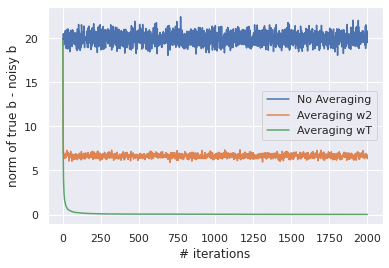

In [ ]:
#@title
plt.plot(b_noAvg[0],b_noAvg[1],label='No Averaging')
plt.plot(b_w2Avg[0],b_w2Avg[1],label='Averaging w2')
plt.plot(b_wTAvg[0],b_wTAvg[1],label='Averaging wT')
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('norm of true b - noisy b')

From this plot, it seems like it would be beneficial to use the strategy presented in *b_test2* to somewhat recover the true value of $b^*$, as the value of the norm of their difference squared is lower than the other two strategies, suggesting that the values of $b_i$ from using that strategy are closer to $b^*$ than the others.

To that end, we then created code which returns the norm of the error squared, which is defined as $||e_k||^2 = ||x^* - x_k||^2$, for each iteration $k$ of the Random Kaczmarz (RK) method. One function represents doing RK using the value of $b$ you receive at each iteration and the other function represents doing RK where as you go through the method you are also averaging the values of $b$ according to the strategy for *b_test2*.

In [ ]:
def randomKaczmarzNoisyNoAvg(A,b,num_iter,var):
  m = A.shape[0]
  x_k = np.zeros((A.shape[1],1))
  prob = [0]*m
  error = [0]*num_iter
  for j in range(m):
    prob[j] = (np.linalg.norm(A[j])**2)/(np.linalg.norm(A)**2)
  for i in range(num_iter): 
    noise = 1*np.random.normal(0, var, size=(m,1))
    r = np.random.choice(range(m),p=prob)
    coef = ((b[r][0]+noise[r])-A[r]*x_k)/(A[r]*A[r].T)
    x_k_new = x_k + coef.item()*(A[r].T)
    x_k = x_k_new
    error[i] = np.linalg.norm(x_k-x)**2
    
  return [x_k,error,list(range(num_iter-1))]

In [ ]:
def randomKaczmarzNoisyWAvg(A,b,num_iter,var):
  m = A.shape[0]
  x_k = np.zeros((A.shape[1],1))
  prob = [0]*m
  error = [0]*num_iter
  bvals=[0]*(num_iter)
  bvals[0]=np.random.normal(0, var, size=(m,1))+b
  for j in range(m):
    prob[j] = (np.linalg.norm(A[j])**2)/(np.linalg.norm(A)**2)
  for i in range(num_iter-1): 
    noise = 1*np.random.normal(0, var, size=(m,1))
    new_measurement = b+noise
    b_r = (new_measurement + (i+1)*bvals[i])/(i+2)
    bvals[i+1]=b_r
    r = np.random.choice(range(m),p=prob)
    coef = ((bvals[i+1][r])-A[r]*x_k)/(A[r]*A[r].T)
    x_k_new = x_k + coef.item()*(A[r].T)
    x_k = x_k_new
    error[i] = np.linalg.norm(x_k-x)**2
  return [x_k,error,list(range(num_iter-1))]

In [ ]:
#@title
dataNoAvg = randomKaczmarzNoisyNoAvg(A,b,100000,0.001)
dataWAvg = randomKaczmarzNoisyWAvg(A,b,100000,0.001)

Below we've plotted the value of the norm of the error squared vs the # of iterations using an "averaging" and a "non-averaging" approach.

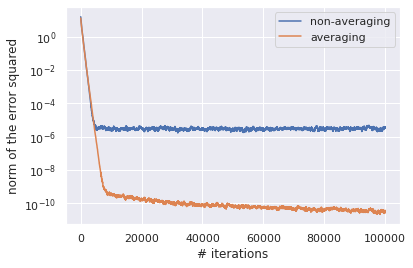

In [ ]:
#@title
plt.semilogy(dataNoAvg[2],dataNoAvg[1][:99999],label="non-averaging")
plt.semilogy(dataWAvg[2],dataWAvg[1][:99999],label="averaging")
plt.xlabel('# iterations')
plt.ylabel('norm of the error squared')
plt.legend()

Agreeing with our expectations, the averaging approach seems to converge to a solution closer to the true solution than simply not taking the average at all. ☺

# Comparison with Non-Noisy $b$

Below is the code for RK without noise being added at each iteration.

In [ ]:
def randomKaczmarz(A,b,num_iter):
  m = A.shape[0]
  x_k = np.zeros((A.shape[1],1))
  prob = [0]*m
  error = [0]*num_iter
  for j in range(m):
    prob[j] = (np.linalg.norm(A[j])**2)/(np.linalg.norm(A)**2)
  for i in range(num_iter): 
    r = np.random.choice(range(m),p=prob)
    coef = (b[r][0]-A[r]*x_k)/(A[r]*A[r].T)
    x_k_new = x_k + coef.item()*(A[r].T)
    x_k = x_k_new
    error[i]=np.linalg.norm(x_k-x)**2
  return [x_k,list(range(num_iter)),error]

In [ ]:
dataNoNoise = randomKaczmarz(A,b,100000)

Below is a plot which compares the error between the "non-averaging", "averaging", and "no noise" situations by looking at norm of the error squared vs # iterations.

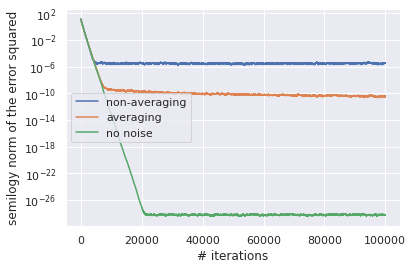

In [ ]:
plt.semilogy(dataNoAvg[2],dataNoAvg[1][:99999],label="non-averaging")
plt.semilogy(dataWAvg[2],dataWAvg[1][:99999],label="averaging")
plt.semilogy(dataNoNoise[1],dataNoNoise[2],label="no noise")
plt.xlabel('# iterations')
plt.ylabel('semilogy norm of the error squared')
plt.legend()

The plot above shows that up to a certain threshold we approach the true solution with all three methods. Using the averaging strategy we can see that it looks like as time goes on we may improve the accuracy of our solution.

A prediction we have for a value of the threshold is the variance of the gaussian distribution.